<a href="https://colab.research.google.com/github/rigonzal/ML-2019-1/blob/master/Tarea3/Tarea3_Pregunta2_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INF-393: Máquinas de Aprendizaje

## Tarea 3 - Pregunta 2

13-09-2019



*   Rodrigo González Smith           -- 201303026-2
*   Ignacio Valenzuela Albornoz   -- 201473055-1

## Clasificación con clases desbalanceadas

In [1]:
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from keras.layers import Dense
from keras.models import Sequential
from imblearn.over_sampling import SMOTE, ADASYN

drive.mount('/content/drive')

%matplotlib inline

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Un problema bastante común cuando se quiere aplicar modelos de aprendizaje automático a problemas de clasificación es el desbalanceo de clases. Esto último consiste en que en los datos etiquetados, cada clase del target posee diferentes cantidades de datos que la representen, habiendo problemas con las clases que las representan pocos datos. Esto es un grandísimo problema en problemas de clasificación binaria, por ejemplo, ya que solo obtendremos resultados para una clase. Con lo anterior, tendremos un modelo bastante simple que entre blanco y negro siempre nos devolverá negro, debido a que en toda su vida ha visto este color y pocas veces el blanco.

Ocuparemos un dataset que posee una gran cantidad de transacciones bancarias las cuales a sus atributos se les aplicó PCA a excepción de ciertas columnas. El problema en cuestión es identificar que transacciones bancarias son propensas a fraude, pero como es de suponer, la cantidad de transacciones fraudulentas son muy pocas, 487 de un total de 285000. ¿Qué podemos hacer en este caso, donde las transacciones fraudulentas representan casi el 2% del total? Comenzaremos ahora a trabajar este dataset para lograr encontrar soluciones a estos problemas, y no tener que ir al engorroso trabajo de crear datos a mano conociendo los factores que resaltan en estas 487 muestras.

## a) Carga de datos
Cargaremos los datos mediante pandas y también analizaremos el tipo de datos de cada atributo, su rango y más información importante.


In [0]:
data = pd.read_csv("/content/drive/My Drive/creditcard.csv")

In [0]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Podemos ver cierta estructura de los datos. Vemos que desde v1 a v28 consisten en los vectores resultantes del PCA. Respecto a la variable Time esta representado en segundos respecto a la primera transacción, es decir, esa columna indica el delta T entre la primera transacción y la actual. Por último tenemos Amount que indica la cantidad de dinero que consistió esa transacción (supondremos en dólares) y por último class, donde por los valores tan bajos de media asimilamos que 0 corresponde a no fraude y un 1 como fraude.

Ahora crearemos una matriz de correlación para ver como los atributos se relacionan entre sí.

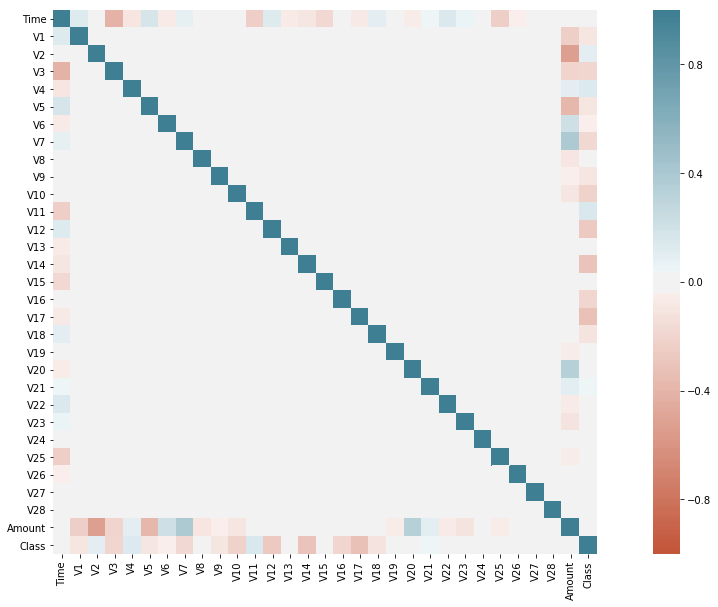

In [0]:
plt.figure(figsize=(20,10))
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

Analizando la matriz, tenemos que un color blanco implica que no hay una correlación entre las variables. Si es verde, implica una correlación positiva y rojo una correlación negativa, y mientras más intenso el color, la magnitud es aún más.

Podemos apreciar que entre los vectores producidos por el PCA no poseen correlación entre sí, lo que es esperable y beneficioso para el modelo (considerando que no se puede reducir más la cantidad). 

Viendo la matriz y analizando tanto los valores del tiempo como su incidencia en el problema, no será una buena opción mantenerlo en el dataset. Esto principalmente a que el tiempo de cada transacción es respecto a la primera de ellas, y en el caso de fraudes no hay tanta implicancia respecto a la secuencia en la que ocurrió. Quizás podríamos obtener alguna información de mes, festividad, año, etc, pero como todo depende la primera transacción, no nos dará ninguna información relevante para le problema, por lo que podemos sacarlo del dataset.

In [0]:
data = data.drop(["Time"], axis = 1)

Por último, veremos si realmente tenemos una pequeña cantidad de muestras categorizados como fraude:

In [0]:
data.loc[lambda x: x.Class != 0].shape

(492, 30)

## b) Ligero pre-procesamiento

Primero que todo debemos realizar un preprocesamiento. Analizando la columna de "Amount", tenemos lo siguiente:

In [0]:
data["Amount"].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

Como se aprecia en el describe, esta columna posee un valor mínimo 0 y un máximo de 25691, con una media de 88 y desviación estándar 250. Los valores tienen un rango bastante alto y eso en los modelos puede tender a producir errores también grandes. Escalar estos datos será crucial para poder acotar su valor y también lograr que tomen valores negativos, barriendo así mejor el espacio en el cual pertenecen. Usaremos un escalador estándar entrenado en el mismo atributo para así transformarlo.

In [0]:
scaler = StandardScaler()
scaler.fit(data['Amount'].values.reshape(-1,1))
data['Amount'] = scaler.transform(data['Amount'].values.reshape(-1,1))

Es evidente que el target no es necesario escalarlo como también el atributo Time que fue eliminado. Respecto a los atributos vX, no es necesario escalarlos ya que son resultado de un PCA, por lo que su rango ya está limitado.

Separaremos el target de los demás atributos, para finalmente aplicar un train_test_split a la muestra, teniendo así listo todo para los modelos de aprendizaje que utilizaremos.

In [0]:
x = data[data.columns[1:-2]]
y = data.Class

In [0]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2)

Comprobemos que en ambos conjuntos poseemos una proporción parecida de clases.

In [0]:
print("Proportion training: ", round((y_train.value_counts()[1] / len(y_train)) * 100, 2))
print("Proportion validation: ", round((y_val.value_counts()[1] / len(y_val)) * 100, 2))

Proportion training:  0.17
Proportion validation:  0.17


Como vemos, la proporción es la misma, por lo que tenemos bien distribuida la cantidad de clases en ambos conjuntos.

Lo anterior es importante debido a que podemos tener casos donde todas las muestras de clase 1 nos quedasen en el conjunto de validación. Por lo tanto, si entrenamos cualquier modelo con un dataset con una sola clase, tendremos un modelo que solo conoce una salida y no puede dar otra. Por lo tanto cuando intente predecir los datos de otra clase no podrá dar un valor, ya que en el aprendizaje supervisado nunca vió una muestra con clase 1, por lo tanto no la conoce.

Además, como tenemos clases desbalanceadas, a pesar de eso igual tendrá un desempeño excelente, debido a que la cantidad de datos que son de clase 1 es cercano al 2%, por lo que a las demás muestras las categorizará perfecto, dandonos una pequeña ilusión de que al fin hicimos algo bien.

## c) Regresor logístico

El regresor logístico siempre es un buen modelo de acercamiento a un problema de clasificación, sobre todo binario. Ocuparemos un modelo simple y veremos su desempeño en ambos conjuntos.

In [0]:
ini = time.time()
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
fin = time.time()
print("Elapsed time: ", fin - ini)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Elapsed time:  3.72574520111084


In [0]:
print("Training score: ", log_reg.score(x_train, y_train))
print("Validation score: ", log_reg.score(x_val, y_val))

Training score:  0.9992012113498212
Validation score:  0.9992275552122467


El desempeño es magnífico, pero también nos da indicio que es overfitting. Aún así, era algo sumamente esperable debido al desbalance de clases. En realidad, ¿por qué hacemos esto si sabemos que el conjunto es demasiado injusto con la clase precaria? Quién sabe...

## d) Always 0

Considerando que hay tan pocas muestras con fraude, ¿que pasaría si nuestro modelo nos devolviera que todos los datos son "no fraude"?. Esto sería lo mismo a que un modelo nos devolviera lo siguiente:

In [7]:
y_preds = pd.np.zeros(y_val.shape)
y_preds

array([0., 0., 0., ..., 0., 0., 0.])

Aún teniendo este y_preds, nuestro modelo tendría un score bastante bueno y que, si no conociésemos bien la data, creeríamos que estaría haciendo overfitting. 

## e) Matriz de confusión

Una métrica muy utilizada en modelos de machine learning para analizar su desempeño es generar una matriz de confusión. Esta consiste en una matriz que contea los aciertos para cada target como también los falsos positivos o negativos, en este caso.

En esta función de abajo podemos apreciar como es una matriz de confusión.

In [0]:
def createMatrix(y_val, y_pred):
  sns.heatmap(confusion_matrix(y_val, y_pred),cmap='summer', annot=True)    

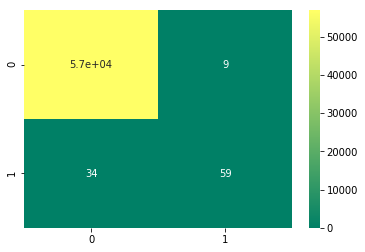

In [0]:
createMatrix(y_val, log_reg.predict(x_val))

Como podemos ver, todos los aciertos se centran en el acierto de la clase 0 y es principalmente por la gran cantidad de muestras que existen con ese label. Aún así, podemos ver que acierta algunas muestras como un fraude a pesar de su poca frecuencia. Aún así, el modelo tiende a tomar muestras que presentan fraude como si no tuvieran (34 de ellas) y muy pocas muestras que no eran fraude las consideró como tal (8 muestras). Lo importante de esto es que podemos apreciar sustancialmente como se enfoca en un solo resultado. 

Por otra parte, si analizamos el y_pred con lo obtenido en el inciso d:

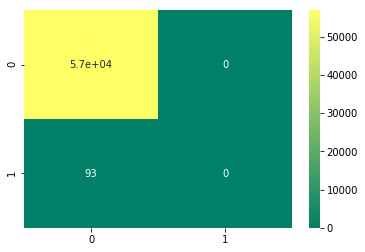

In [0]:
createMatrix(y_val, y_preds)

Como habíamos discutido en el mismo inciso d, el modelo solo tendrá en su conocimiento la clase 0, por lo que claramente tomará cualquier entrada como tal. Por eso no tenemos falsos positivos ni verdaderos positivos. El modelo no conoce ni una muestra con fraude, por lo que nunca nos logrará devolver una muestra con esa etiqueta.

## f) Curva ROC

La curva ROC es un tipo de gráfico que considerando un problema de clasificación binaria, podemos analizar la habilidad de este modelo mientras su umbral de decisión cambia durante el entrenamiento. 

Esto consiste en tomar el ratio de los verdaderos positivos y de los falsos positivos y graficarlos en un plot x vs y, donde x son los falsos positivos e y los verdaderos positivos. La idea es obtener una curva que crece bastante rápido en el inicio y luego se mantiene constante como una función y = 1. Esto es principalmente porque mientras aumenta el ratio de los falsos positivos, también el de verdaderos positivos, y un ratio de 1 significa que va logrando tener una mejor clasificación cuando corresponde.

Obviamente nos interesa que sean los positivos debido a que esta clase representa los fraudes, la clase desbalanceada, y buscamos que los modelos sean más certeros en esa categorización

In [0]:
def constructROC(y_train, x_train):
  fpr, tpr, _ = roc_curve(y_train, x_train[:,1],pos_label=1)
  plt.plot(fpr, tpr)

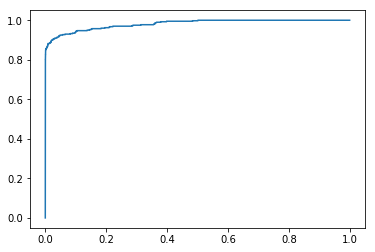

In [0]:
constructROC(y_train, log_reg.predict_proba(x_train))

## g) Árbol de clasificación

Ahora debemos buscar otro modelo que le pueda hacer la competencia al regresor logístico. En realidad, ya sabemos que el problema nace de nuestro dataset, pero podemos también analizar el tiempo de cómputo, por ejemplo, como también como se comportan los modelos gracias a las métricas anteriormente mostradas. Utilizaremos 3 árboles que se diferenciarán por su profundidad. 

In [0]:
tree_3 = DecisionTreeClassifier(criterion='gini', max_depth=3)
tree_5 = DecisionTreeClassifier(criterion='gini', max_depth=5)
tree_7 = DecisionTreeClassifier(criterion='gini', max_depth=7)

ini = time.time()
tree_3.fit(x_train, y_train)
fin = time.time()
print("3 depth tree time: ", fin - ini)
ini = time.time()
tree_5.fit(x_train, y_train)
fin = time.time()
print("5 depth tree time: ", fin - ini)
ini = time.time()
tree_7.fit(x_train, y_train)
fin = time.time()
print("7 depth tree time: ", fin - ini)

3 depth tree time:  3.6931796073913574
5 depth tree time:  5.7682836055755615
7 depth tree time:  8.30238652229309


Ahora comparemos el desempeño de cada uno de los modelos de árbol con la lineal.

In [0]:
print("Training score logistic: ", log_reg.score(x_train, y_train))
print("Training score 3 tree: ", tree_3.score(x_train, y_train))
print("Training score 5 tree: ", tree_5.score(x_train, y_train))
print("Training score 7 tree: ", tree_7.score(x_train, y_train))
print("-------------------------------------")
print("Validation score logistic: ", log_reg.score(x_val, y_val))
print("Validation score 3 tree: ", tree_3.score(x_val, y_val))
print("Validation score 5 tree: ", tree_5.score(x_val, y_val))
print("Validation score 7 tree: ", tree_7.score(x_val, y_val))

Training score logistic:  0.9992012113498212
Training score 3 tree:  0.9993416577058966
Training score 5 tree:  0.9995654940858917
Training score 7 tree:  0.9996752178015756
-------------------------------------
Validation score logistic:  0.9992275552122467
Validation score 3 tree:  0.9992977774656788
Validation score 5 tree:  0.9994733330992591
Validation score 7 tree:  0.9995435553526912


Es el momento de las métricas, y aquí utilizaremos matrices de confusión como también la curva ROC

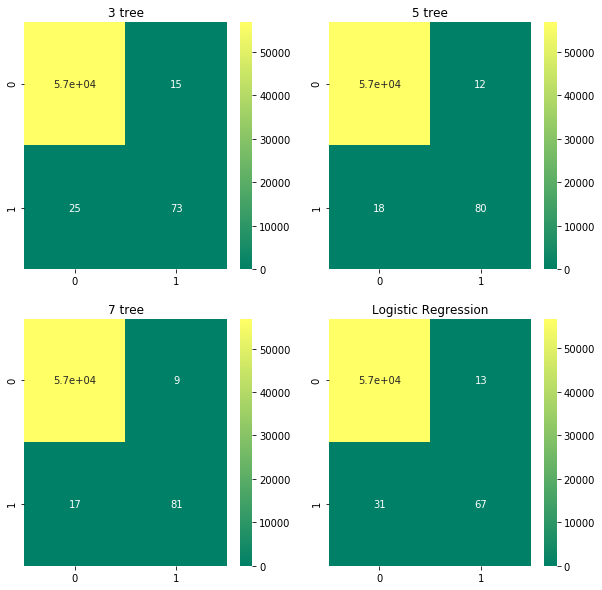

In [0]:
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.title("3 tree")
createMatrix(y_val, tree_3.predict(x_val))
plt.subplot(2, 2, 2)
plt.title("5 tree")
createMatrix(y_val, tree_5.predict(x_val))
plt.subplot(2, 2, 3)
plt.title("7 tree")
createMatrix(y_val, tree_7.predict(x_val))
plt.subplot(2, 2, 4)
plt.title("Logistic Regression")
createMatrix(y_val, log_reg.predict(x_val))

Lo interesante que podemos ver en los árboles que poseen un mejor desempeño al etiquetar correctamente los 1, es decir, un mejor verdadero positivo. El árbol de 5 hojas es el que posee una menor cantidad de falsos positivos y negativos, por lo que ahora podemos definir que el árbol esta haciendo un mejor trabajo etiquetando las muestras que son fraudes.

Ahora, analizando la curva ROC, tenemos lo siguiente:

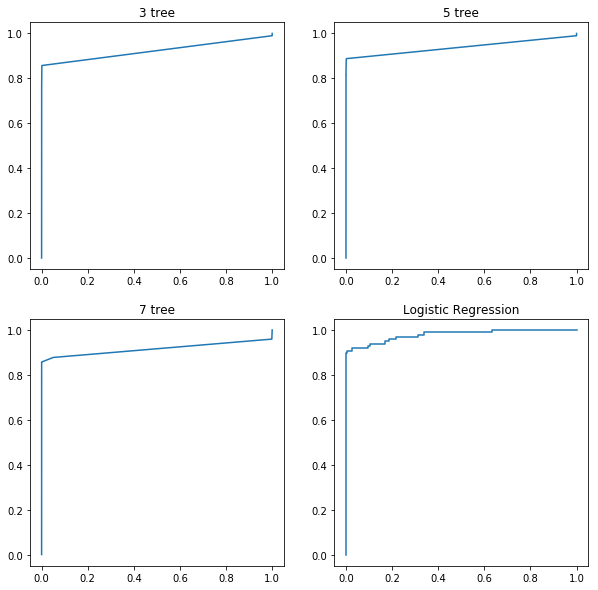

In [0]:
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.title("3 tree")
constructROC(y_val, tree_3.predict_proba(x_val))
plt.subplot(2, 2, 2)
plt.title("5 tree")
constructROC(y_val, tree_5.predict_proba(x_val))
plt.subplot(2, 2, 3)
plt.title("7 tree")
constructROC(y_val, tree_7.predict_proba(x_val))
plt.subplot(2, 2, 4)
plt.title("Logistic Regression")
constructROC(y_val, log_reg.predict_proba(x_val))

Respecto a las curvas ROC, vemos que aumenta paulatinamente los ratios de los árboles, mientras la de regresión logística tiende a ser más constante en el transcurso. Una buena forma de ver el desempeño de estas curvas ROC es calcular el AUC (Area Under Curve) de estos modelos, y el que nos devuelva le mayor será el escogido. 

In [0]:
probs_3 = tree_3.predict_proba(x_val)
probs_5 = tree_5.predict_proba(x_val)
probs_7 = tree_7.predict_proba(x_val)
probs_log = log_reg.predict_proba(x_val)

print("AUC score 3 tree: ", roc_auc_score(y_val, probs_3[:, 1]))
print("AUC score 5 tree: ", roc_auc_score(y_val, probs_5[:, 1]))
print("AUC score 7 tree: ", roc_auc_score(y_val, probs_7[:, 1]))
print("AUC score logistic: ", roc_auc_score(y_val, probs_log[:, 1]))

AUC score 3 tree:  0.9232436432648468
AUC score 5 tree:  0.9385810792381104
AUC score 7 tree:  0.9158098664339117
AUC score logistic:  0.978504028229187


Y como se puede apreciar, la regresión logística posee una mejor área bajo la curva. 

## h) Undersampling

Ocupando diferentes modelos podemos mejorar un poco los verdaderos positivos, pero en caso que tengamos nuevas muestras, la ausencia de un dataset con clases balanceadas siempre será un problema, por lo que debemos generar soluciones que afecten directamente al dataset.

Una de ellas es el undersampling, el cual consiste en disminuir la cantidad de muestras con la clase dominante para así tener un equilibrio entre ellas.

Para esta misma tarea, generaremos una función que se encargará de esto. Esta función separará las muestras respecto a su target para luego aplicar un random choice. El random choice tomará las muestras con target 0 y devolverá una cantidad "count_fraud_transaction" * times, la cual haremos que la muestra 0 sea n veces más grande que la cantidad de muestras 1. Random choice devolverá muestras al azar de los índices normales. Como la idea es tener la cantidad de muestras más variada posible, debemos asignar la variable replace con False. Con replace = False, sabemos que tendremos valores únicos en la nueva variable; si es True, se puede repetir alguna muestra en el conjunto. Nuestra idea es reducir la cantidad de muestras 0 pero a la vez sea lo más variada posible. Luego de esto devolverá los conjuntos de entrenamiento y validación que correspondan.

In [0]:
def undersample(df, times = 10, validation_ratio = 0.2):
    fraud_indices = pd.np.array(df[df.Class==1].index)
    normal_indices = pd.np.array(df[df.Class==0].index)

    Count_Fraud_transaction = len(fraud_indices)
    
    Normal_indices_undersample = pd.np.array(
    pd.np.random.choice(normal_indices,
        Count_Fraud_transaction * times,
        replace = False)
    )
    
    undersample_data = pd.np.concatenate([fraud_indices,Normal_indices_undersample])
    undersample_data = df.iloc[undersample_data]
    
    x = undersample_data[undersample_data.columns[1:-2]]
    y = undersample_data.Class
        
    return train_test_split(x, y, test_size = validation_ratio)

## i) Entrenar con undersampling

Tenemos nuestra función preparada. En esta ocasión, como los árboles mostraron un mejor desempeño que la regresión logística, solo utilizaremos estos para la comparación. Usaremos 4 valores de times diferentes y vemos como va afectando el desempeño del modelo mientras la razón entre las clases va cambiando.

In [0]:
# 1 times

x1_train, x1_val, y1_train, y1_val = undersample(data, 1, 0.2)
tree1_3 = DecisionTreeClassifier(criterion='gini', max_depth=3)
tree1_5 = DecisionTreeClassifier(criterion='gini', max_depth=5)
tree1_7 = DecisionTreeClassifier(criterion='gini', max_depth=7)

tree1_3.fit(x1_train, y1_train)
tree1_5.fit(x1_train, y1_train)
tree1_7.fit(x1_train, y1_train)

# 10 times

x10_train, x10_val, y10_train, y10_val = undersample(data, 10, 0.2)
tree10_3 = DecisionTreeClassifier(criterion='gini', max_depth=3)
tree10_5 = DecisionTreeClassifier(criterion='gini', max_depth=5)
tree10_7 = DecisionTreeClassifier(criterion='gini', max_depth=7)

tree10_3.fit(x10_train, y10_train)
tree10_5.fit(x10_train, y10_train)
tree10_7.fit(x10_train, y10_train)
    
# 50 times

x50_train, x50_val, y50_train, y50_val = undersample(data, 50, 0.2)
tree50_3 = DecisionTreeClassifier(criterion='gini', max_depth=3)
tree50_5 = DecisionTreeClassifier(criterion='gini', max_depth=5)
tree50_7 = DecisionTreeClassifier(criterion='gini', max_depth=7)

tree50_3.fit(x50_train, y50_train)
tree50_5.fit(x50_train, y50_train)
tree50_7.fit(x50_train, y50_train)
    
# 100 times

x100_train, x100_val, y100_train, y100_val = undersample(data, 100, 0.2)
tree100_3 = DecisionTreeClassifier(criterion='gini', max_depth=3)
tree100_5 = DecisionTreeClassifier(criterion='gini', max_depth=5)
tree100_7 = DecisionTreeClassifier(criterion='gini', max_depth=7)

tree100_3.fit(x100_train, y100_train)
tree100_5.fit(x100_train, y100_train)
tree100_7.fit(x100_train, y100_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

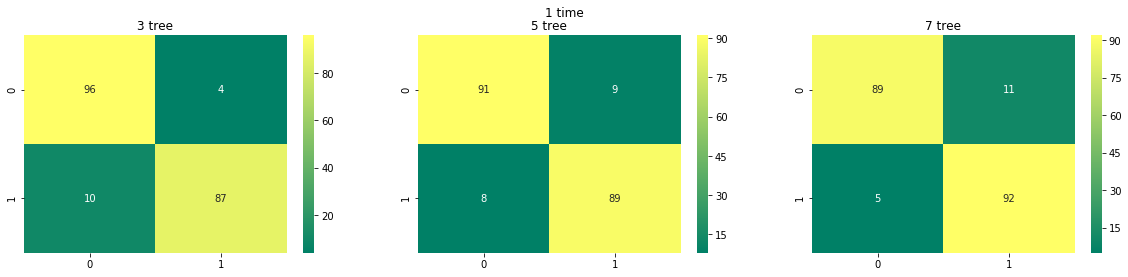

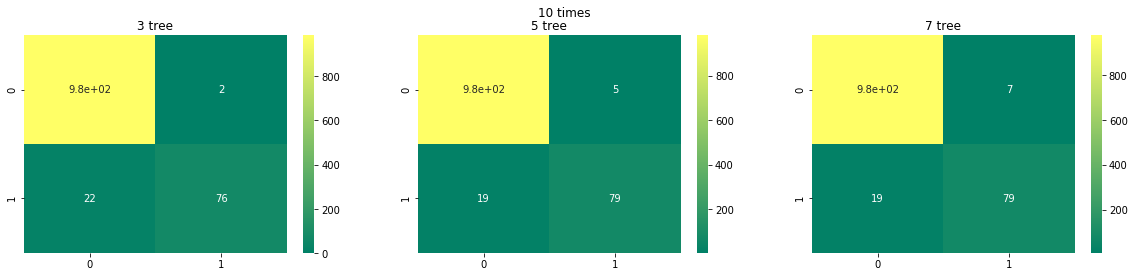

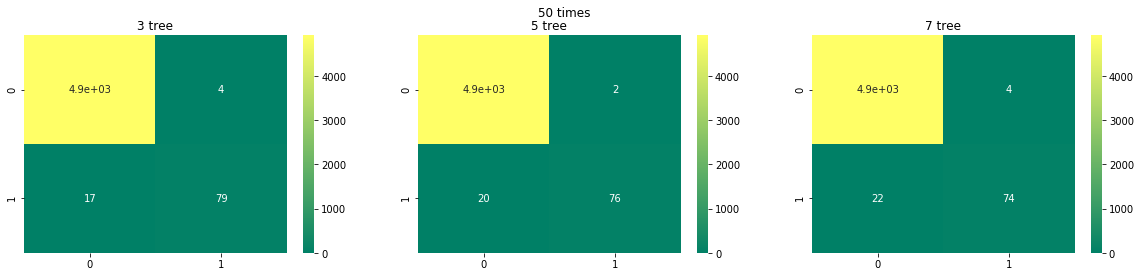

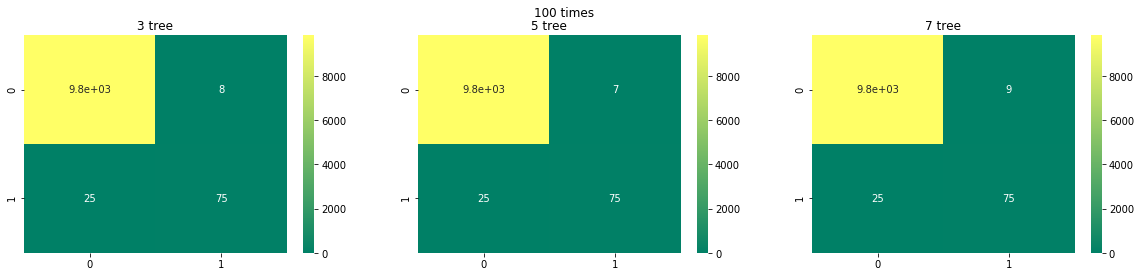

In [0]:
# 1 times
plt.figure(figsize=(20,4))
plt.suptitle("1 time")
plt.subplot(1, 3, 1)
plt.title("3 tree")
createMatrix(y1_val, tree1_3.predict(x1_val))
plt.subplot(1, 3, 2)
plt.title("5 tree")
createMatrix(y1_val, tree1_5.predict(x1_val))
plt.subplot(1, 3, 3)
plt.title("7 tree")
createMatrix(y1_val, tree1_7.predict(x1_val))

# 10 times
plt.figure(figsize=(20,4))
plt.suptitle("10 times")
plt.subplot(1, 3, 1)
plt.title("3 tree")
createMatrix(y10_val, tree10_3.predict(x10_val))
plt.subplot(1, 3, 2)
plt.title("5 tree")
createMatrix(y10_val, tree10_5.predict(x10_val))
plt.subplot(1, 3, 3)
plt.title("7 tree")
createMatrix(y10_val, tree10_7.predict(x10_val))

# 50 times
plt.figure(figsize=(20,4))
plt.suptitle("50 times")
plt.subplot(1, 3, 1)
plt.title("3 tree")
createMatrix(y50_val, tree50_3.predict(x50_val))
plt.subplot(1, 3, 2)
plt.title("5 tree")
createMatrix(y50_val, tree50_5.predict(x50_val))
plt.subplot(1, 3, 3)
plt.title("7 tree")
createMatrix(y50_val, tree50_7.predict(x50_val))

# 100 times
plt.figure(figsize=(20,4))
plt.suptitle("100 times")
plt.subplot(1, 3, 1)
plt.title("3 tree")
createMatrix(y100_val, tree100_3.predict(x100_val))
plt.subplot(1, 3, 2)
plt.title("5 tree")
createMatrix(y100_val, tree100_5.predict(x100_val))
plt.subplot(1, 3, 3)
plt.title("7 tree")
createMatrix(y100_val, tree100_7.predict(x100_val))

Podemos observar que mientras mas equiparamos la cantidad de cada clase obtiene un mejor desempeño en los verdaderos positivos. También mientras aumentamos, disminuye el falso positivo y es claramente al aumentar la cantidad de muestras 0, el modelo obtiene más información respecto a esa clase, por lo que etiquetará mejor. Los falsos negativos también disminuyen mucho cuando los tamaños son parecidos. Respecto a la curva ROC...

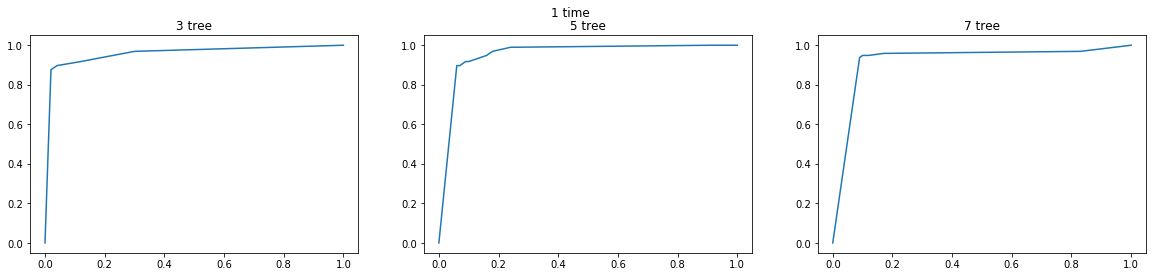

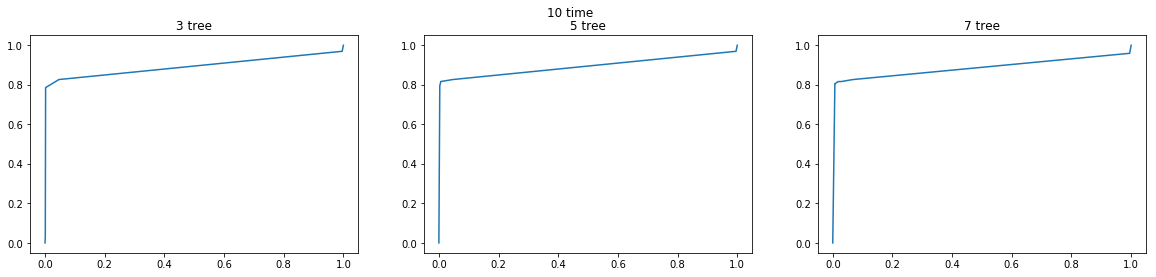

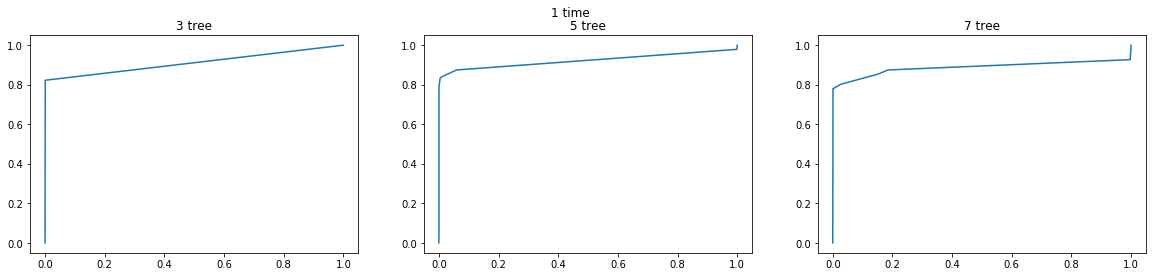

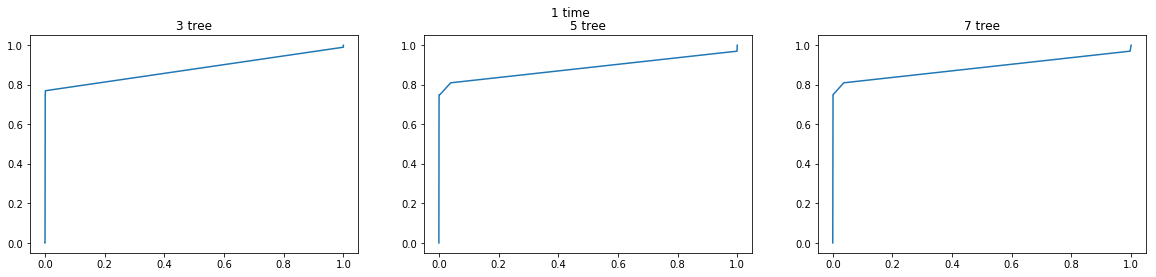

In [0]:
# 1 time
plt.figure(figsize=(20,4))
plt.suptitle("1 time")
plt.subplot(1, 3, 1)
plt.title("3 tree")
constructROC(y1_val, tree1_3.predict_proba(x1_val))
plt.subplot(1, 3, 2)
plt.title("5 tree")
constructROC(y1_val, tree1_5.predict_proba(x1_val))
plt.subplot(1, 3, 3)
plt.title("7 tree")
constructROC(y1_val, tree1_7.predict_proba(x1_val))

# 10 time

plt.figure(figsize=(20,4))
plt.suptitle("10 time")
plt.subplot(1, 3, 1)
plt.title("3 tree")
constructROC(y10_val, tree10_3.predict_proba(x10_val))
plt.subplot(1, 3, 2)
plt.title("5 tree")
constructROC(y10_val, tree10_5.predict_proba(x10_val))
plt.subplot(1, 3, 3)
plt.title("7 tree")
constructROC(y10_val, tree10_7.predict_proba(x10_val))

# 50 time

plt.figure(figsize=(20,4))
plt.suptitle("1 time")
plt.subplot(1, 3, 1)
plt.title("3 tree")
constructROC(y50_val, tree50_3.predict_proba(x50_val))
plt.subplot(1, 3, 2)
plt.title("5 tree")
constructROC(y50_val, tree50_5.predict_proba(x50_val))
plt.subplot(1, 3, 3)
plt.title("7 tree")
constructROC(y50_val, tree50_7.predict_proba(x50_val))

# 100 time

plt.figure(figsize=(20,4))
plt.suptitle("1 time")
plt.subplot(1, 3, 1)
plt.title("3 tree")
constructROC(y100_val, tree100_3.predict_proba(x100_val))
plt.subplot(1, 3, 2)
plt.title("5 tree")
constructROC(y100_val, tree100_5.predict_proba(x100_val))
plt.subplot(1, 3, 3)
plt.title("7 tree")
constructROC(y100_val, tree100_7.predict_proba(x100_val))

Finalmente, probaremos con los AUC para analizar el mejor modelo.

In [0]:
probs1_3 = tree1_3.predict_proba(x1_val)
probs1_5 = tree1_5.predict_proba(x1_val)
probs1_7 = tree1_7.predict_proba(x1_val)

print("---- 1 times ----")
print("AUC score 3 tree: ", roc_auc_score(y1_val, probs1_3[:, 1]))
print("AUC score 5 tree: ", roc_auc_score(y1_val, probs1_5[:, 1]))
print("AUC score 7 tree: ", roc_auc_score(y1_val, probs1_7[:, 1]))

probs10_3 = tree10_3.predict_proba(x10_val)
probs10_5 = tree10_5.predict_proba(x10_val)
probs10_7 = tree10_7.predict_proba(x10_val)

print("---- 10 times ----")
print("AUC score 3 tree: ", roc_auc_score(y10_val, probs10_3[:, 1]))
print("AUC score 5 tree: ", roc_auc_score(y10_val, probs10_5[:, 1]))
print("AUC score 7 tree: ", roc_auc_score(y10_val, probs10_7[:, 1]))

probs50_3 = tree50_3.predict_proba(x50_val)
probs50_5 = tree50_5.predict_proba(x50_val)
probs50_7 = tree50_7.predict_proba(x50_val)

print("---- 50 times ----")
print("AUC score 3 tree: ", roc_auc_score(y50_val, probs50_3[:, 1]))
print("AUC score 5 tree: ", roc_auc_score(y50_val, probs50_5[:, 1]))
print("AUC score 7 tree: ", roc_auc_score(y50_val, probs50_7[:, 1]))

probs100_3 = tree100_3.predict_proba(x100_val)
probs100_5 = tree100_5.predict_proba(x100_val)
probs100_7 = tree100_7.predict_proba(x100_val)

print("---- 100 times ----")
print("AUC score 3 tree: ", roc_auc_score(y100_val, probs100_3[:, 1]))
print("AUC score 5 tree: ", roc_auc_score(y100_val, probs100_5[:, 1]))
print("AUC score 7 tree: ", roc_auc_score(y100_val, probs100_7[:, 1]))

---- 1 times ----
AUC score 3 tree:  0.958041237113402
AUC score 5 tree:  0.953659793814433
AUC score 7 tree:  0.9218556701030929
---- 10 times ----
AUC score 3 tree:  0.8928105252253186
AUC score 5 tree:  0.893395835491557
AUC score 7 tree:  0.8852947270278669
---- 50 times ----
AUC score 3 tree:  0.9111229602545872
AUC score 5 tree:  0.9224336024781636
AUC score 7 tree:  0.8876500186200827
---- 100 times ----
AUC score 3 tree:  0.8794902937290374
AUC score 5 tree:  0.8853857099298709
AUC score 7 tree:  0.8859045634718976


Podemos apreciar que el mejor desempeño tiene la de 1 time, y tiene sentido, debido a que posee la muestra más equitativa entre las demás. Aún así, la que es 50 veces presenta un buen score.

## j) Oversampling

Otra técnica para equiparar el dataset es el oversampling, aunque es más complicado debido a que implica crear nuevos datos sintéticos, y claramente el criterio para crearlos no suele ser tan fácil de establecer. Existen varios métodos, y aquí analizaremos dos de ellos que se llaman SMOTE and ADASYN.

SMOTE: Este es un algoritmo que utilizara KNN. Aplica k nearest neighbors a las muestras con menos presencia a las otras muestras de su misma clase. Cuando encuentra estos vecinos, traza una línea desde la muestra hacia los vecinos y crea nuevas muestras que se sitúan en aquella línea. Por lo tanto genera datos sintéticos considerando los datos de la muestra deficiente y comparándolo con su entorno.

ADASYN: Este algoritmo es una mejora de SMOTE, y lo que busca es evitar cierta correlación entre los datos reales y los generados, debido a que como se realizan con un KNN y la distancia entre la muestra y sus vecinos, la correlación puede estar muy presente en los datos. Por lo tanto, a las muestras les agrega cierto valor random aplicandole cierta varianza y así reducir la correlación.

En esta ocasión utilizaremos ADASYN ya que nos interesa que los datos no presenten cierta correlación entre ellos, principalmente porque haría a estos datos linealmente dependientes en caso de SMOTE (ya que la nueva muestra se genera en la misma línea entre un punto y su vecino) lo que nos permite ingresar cierto ruido a la muestra y así el modelo se adapte mejor, ya que probablemente cuando se ingresen nuevos datos en el futuro, las transacciones fraudulentas también pueden representar cierto ruido en comparación con las muestras que ya poseemos.

Para esta ocasión utilizaremos los parámetros por defecto, pero es igualmente analizar cual es la implicancia de ellos en el algoritmo:


*   sampling_strategy: Es un parámetro bastante complejo, ya que dependiendo del tipo de variable que se le asigne realiza cierta acción, además que si es un string, por ejemplo, puede ser muchos valores distintos. Pero a grandes rasgos, implica la estrategia para re-ordenar los datos después de la generación.
*   random_state: Define el estado aleatorio del algoritmo, principalmente generado por una semilla. Se puede definir una para que siempre genere los mismos números o dejarla como None para que la semilla de numpy realize el trabajo.
*   n_neighbors: Define la cantidad de vecinos que se comparará por cada muestra. 
*   n_jobs: La cantidad de hilos que se usarán en el algoritmo.

Generaremos un nuevo dataset con esta muestra y separaremos en training y validación. Luego, probaremos con los 3 árboles que definimos anteriormente y aplicaremos las mismas métricas.


In [0]:
ada = ADASYN()
x_tr_r, y_tr_r  = ada.fit_resample(x_train,y_train)

In [13]:
tree_over_3 = DecisionTreeClassifier(criterion='gini', max_depth=3)
tree_over_5 = DecisionTreeClassifier(criterion='gini', max_depth=5)
tree_over_7 = DecisionTreeClassifier(criterion='gini', max_depth=7)

tree_over_3.fit(x_tr_r, y_tr_r)
tree_over_5.fit(x_tr_r, y_tr_r)
tree_over_7.fit(x_tr_r, y_tr_r)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Y ahora veremos las métricas...

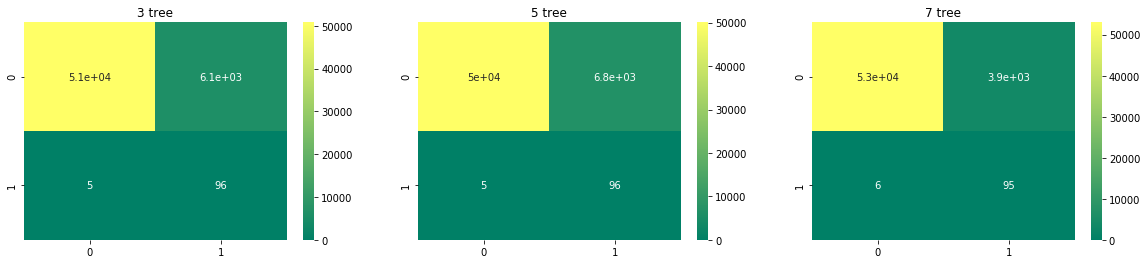

In [15]:
plt.figure(figsize=(20,4))
plt.subplot(1, 3, 1)
plt.title("3 tree")
createMatrix(y_val, tree_over_3.predict(x_val))
plt.subplot(1, 3, 2)
plt.title("5 tree")
createMatrix(y_val, tree_over_5.predict(x_val))
plt.subplot(1, 3, 3)
plt.title("7 tree")
createMatrix(y_val, tree_over_7.predict(x_val))

Podemos apreciar que incluso los verdaderos positivos superaron a los verdaderos negativos. Aún así, los falsos aumentaron considerablemente en el mismo nivel de magnitud, lo que nos debería dar un score más bajo. De hecho:

In [16]:
print(tree_over_3.score(x_val, y_val))
print(tree_over_5.score(x_val, y_val))
print(tree_over_7.score(x_val, y_val))

0.8932797303465468
0.8806221691654085
0.932042414241073


Aún así, obtenemos un gran score, incluso el árbol con menos nodos con un score que tiende menos al overfitting. Analizando las curvas ROC.

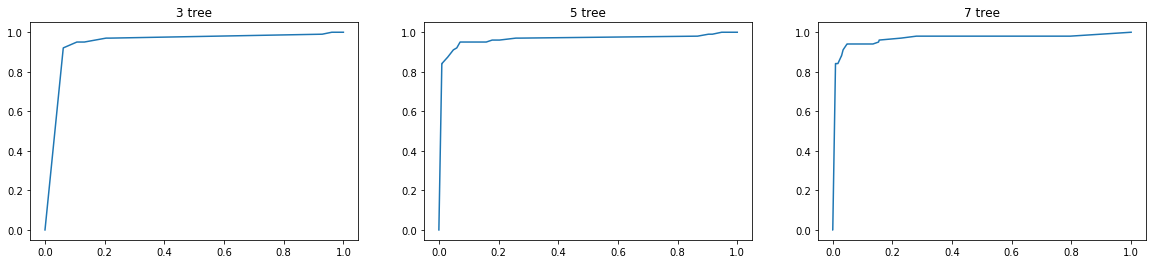

In [17]:
plt.figure(figsize=(20,4))
plt.subplot(1, 3, 1)
plt.title("3 tree")
constructROC(y_val, tree_over_3.predict_proba(x_val))
plt.subplot(1, 3, 2)
plt.title("5 tree")
constructROC(y_val, tree_over_5.predict_proba(x_val))
plt.subplot(1, 3, 3)
plt.title("7 tree")
constructROC(y_val, tree_over_7.predict_proba(x_val))


Podemos apreciar a simple vista que el modelo de 7 nodos posee una buena gráfica. Analizando las áres bajo la curva:

In [18]:
probs_over_3 = tree_over_3.predict_proba(x_val)
probs_over_5 = tree_over_5.predict_proba(x_val)
probs_over_7 = tree_over_7.predict_proba(x_val)

print("---- 1 times ----")
print("AUC score 3 tree: ", roc_auc_score(y_val, probs_over_3[:, 1]))
print("AUC score 5 tree: ", roc_auc_score(y_val, probs_over_5[:, 1]))
print("AUC score 7 tree: ", roc_auc_score(y_val, probs_over_7[:, 1]))

---- 1 times ----
AUC score 3 tree:  0.9452420972386892
AUC score 5 tree:  0.9636808433837527
AUC score 7 tree:  0.9678499470917529


Como habíamos predicho, el área bajo la curva del árbol de 7 nodos presenta el mayor valor. También se entiende ya que obtiene el mejor desempeño para los verdaderos positivos y negativos.

## k) Redes neuronales Feed Forward

Por último, nos queda probar el modelo del momento: redes neuronales. Aunque las redes neuronales en la actualidad obtienen un gran desempeño, son subseptibles al desbalanceo de clases y también a la poca cantidad de datos. Pero estos dos factores ya los hemos resuelto en las etapas anteriores, por lo que no hay problemas para implementarlo. Primero crearemos una capa densa con 256 neuronas con una función de activación ReLU y finalizando con una capa de salida con una neurona y función de activación sigmoidal. 

Debemos definir los parámetros para el entrenamiento, definiendo un optimizador con gradiente descendente estocástico, una función de pérdida de crossentropy binario y, por ahora, nos interesa el accuracy del modelo. Finalmente lo entrenaremos con los datos obtenidos con el oversampling con 20 épocas (o iteraciones), utilizando un conjunto de validación para ir analizando el avance del algoritmo, para así en caso de estancamiento del score de validación podamos detenerlo de forma prematura.

In [20]:
model = Sequential()

model.add(Dense(256,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='sgd',
             loss='binary_crossentropy',
             metrics=['accuracy'])
ini = time.time()
history = model.fit(x_tr_r,y_tr_r, epochs=20, validation_data=(x_val,y_val))
fin = time.time()
print("Elapsed time: ", fin - ini, "[s]")




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 454895 samples, validate on 56962 samples
Epoch 1/20
454895/454895 [==============================] - 18s 39us/step - loss: 0.1293 - acc: 0.9632 - val_loss: 0.0857 - val_acc: 0.9706
Epoch 2/20
454895/454895 [==============================] - 17s 37us/step - loss: 0.0494 - acc: 0.9891 - val_loss: 0.0529 - val_acc: 0.9808
Epoch 3/20
454895/454895 [==============================] - 17s 37us/step - loss: 0.0324 - acc: 0.9927 - val_loss: 0.0394 - val_acc: 0.9863
Epoch 4/20
454895/454895 [==============================] - 17s 38us/step - loss: 0.0244 - acc: 0.9946 - val_loss: 0.0315 - val_acc: 0.9898
Epoch 5/20
454895/454895 [==============================] - 17s 37us/step - loss: 0.0196 - acc: 0.9957 - val_loss: 0.0276 - val_acc: 0.9916
Epoch 6/20
454895/454895 [==============================] - 17s 38us/step - loss: 0.0165 - acc: 0.9964 - val_loss: 0.0254 - val_acc: 0.9922
Epoch 7/20


Tras entrenar, podemos graficar el accuracy con el error en ambos dataset, y también realizar la matriz de confusión y la curva ROC.

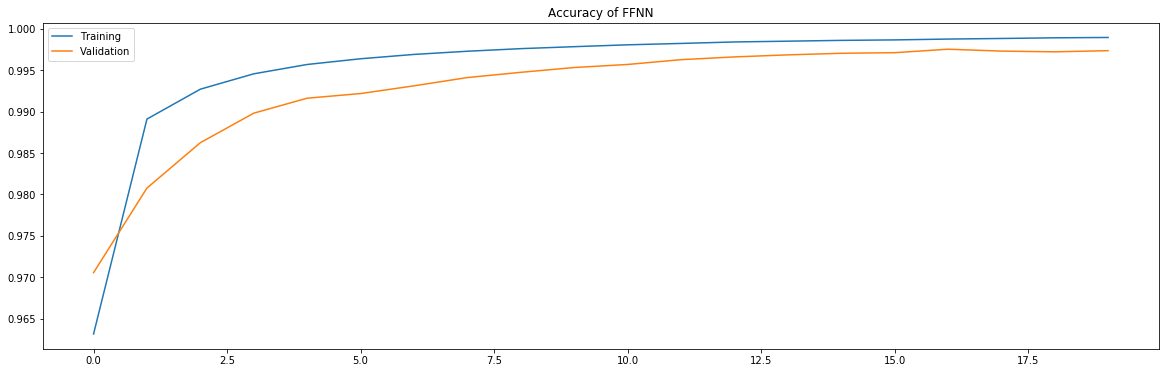

In [21]:
plt.figure(figsize=(20,6))
plt.title("Accuracy of FFNN")
plt.plot(range(0, 20), history.history['acc'])
plt.plot(range(0, 20), history.history['val_acc'])
plt.legend(["Training", "Validation"])

Podemos apreciar que el accuracy aumenta casi en la misma cantidad y siempre aumenta o mantiene constante, por lo que el desempeño se ve bastante bien. Analizando la pérdida:

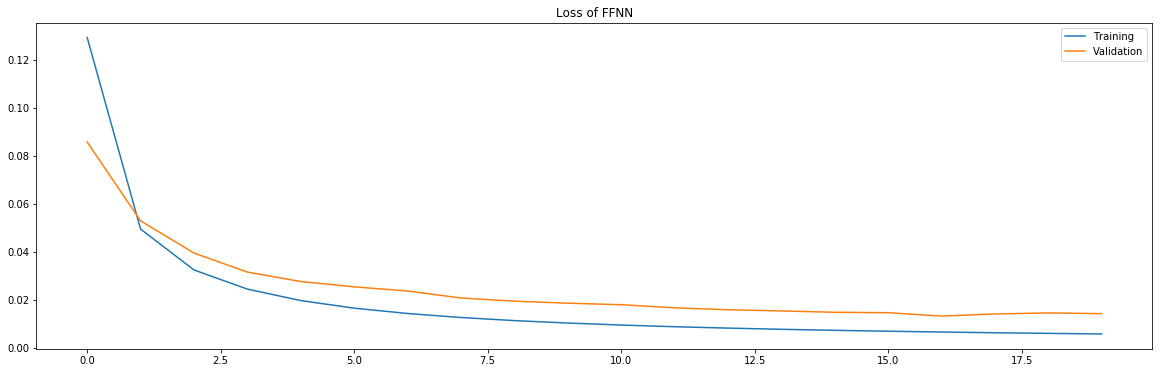

In [22]:
plt.figure(figsize=(20,6))
plt.title("Loss of FFNN")
plt.plot(range(0, 20), history.history['loss'])
plt.plot(range(0, 20), history.history['val_loss'])
plt.legend(["Training", "Validation"])

Lo que también toma bastante sentido. Ahora debemos crear las matrices y curvas ROC para poder comparar con los otros modelos.

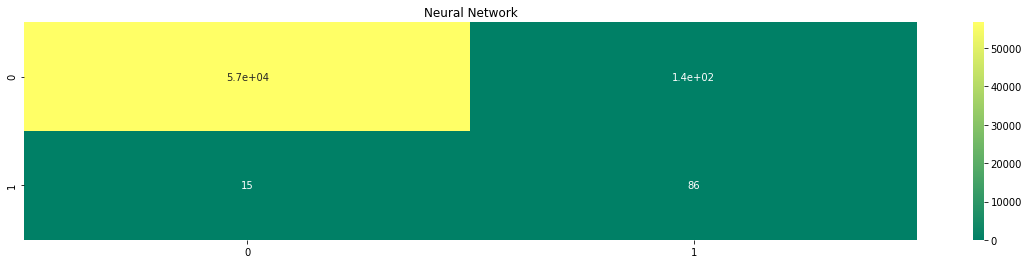

In [23]:
plt.figure(figsize=(20,4))
plt.title("Neural Network")
createMatrix(y_val, model.predict_classes(x_val))

Podemos apreciar que no presenta ningún falso positivo. Aún así, nuestra intención es poder reducir los falsos negativos, ya que son las muestras que corresponden ser positivas.